In [1]:
import os
import torch.optim as optim
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Dataset

In [2]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class MangaDataset(Dataset):
    """Road  dataset"""

    def __init__(self, data_dir: str = 'data', im_size = (64, 64), transform = None):
        """
        data_dir: str - path to images directory
        transform: tochvision.transforms - transforms to be used on images
        """
        if transform:
            self.transform = transforms.Compose([
                transforms.Resize(im_size),
                transforms.ToTensor(),
                transform
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(im_size),
                transforms.ToTensor(),
            ])
        self.dataset = list(map(str, Path(data_dir).rglob("*.jpg")))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Getting index
        if torch.is_tensor(idx):
            idx = idx.tolist()
        im_path = self.dataset[idx]
        # Opening and transforming the image
        with Image.open(im_path) as im:
            gray = ImageOps.grayscale(im)
            return self.transform(gray)

# Data Module

In [3]:
class MangaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = 'data', batch_size: int = 32, train_size: float = 0.8, test_size: float = 0.15):
        """
        data_dir: string, paht ot directory of images
        batch_size: int, size of the batch
        train_size: float, percentage of the train dataset size
        test_size: float, percentage of the test dataset size
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_size = train_size
        self.test_size = test_size

    def setup(self, stage=None):
        data_full = MangaDataset(self.data_dir)
        train_size = int(len(data_full)*self.train_size)
        test_size = int(len(data_full)*self.test_size)
        val_size = len(data_full) - train_size - test_size
        self.manga_train, test_val = random_split(data_full, [train_size, test_size + val_size])
        self.manga_test, self.manga_val = random_split(test_val, [test_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.manga_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.manga_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.manga_test, batch_size=self.batch_size)

# Model

In [4]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

In [54]:
# https://github.com/1Konny/Beta-VAE/blob/master/model.py

class MangaModel(pl.LightningModule):
    def __init__(self, n_size):
        super().__init__()
        self.n_size = n_size
        # Encoder model
        self.encoder = torch.nn.Sequential( # shape (1, 64, 64)
                            torch.nn.Conv2d(1, 32, 4, stride=2, padding=1), # (32, 32, 32)
                            torch.nn.ReLU(), 
                            torch.nn.BatchNorm2d(32),
                            torch.nn.Conv2d(32, 32, 4, stride=2, padding=1), # (32, 16, 16)
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(32),
                            torch.nn.Dropout2d(),
                            torch.nn.Conv2d(32, 64, 4, stride=2, padding=1), # (64, 8, 8)
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.Conv2d(64, 64, 4, stride=2, padding=1), # (64, 4, 4)
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.Conv2d(64, 256, 4, stride=1), # (256, 1, 1)
                            torch.nn.ReLU(),
                            torch.nn.Dropout2d(),
                            torch.nn.BatchNorm2d(256),
                            torch.nn.Flatten(),
                            torch.nn.Linear(256, 2 * n_size)
                        )
        # Decoder model
        self.decoder = torch.nn.Sequential( # shape (64, 28, 28)
                            torch.nn.Linear(n_size, 256),
                            View((-1, 256, 1, 1)),
                            torch.nn.ConvTranspose2d(256, 64, 4, stride=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.Dropout2d(),
                            torch.nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(64),
                            torch.nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(32),
                            torch.nn.Dropout2d(),
                            torch.nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),
                            torch.nn.BatchNorm2d(32),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)
                        )
        # MSE loss
        self.loss = torch.nn.MSELoss()
        
    # https://github.com/1Konny/Beta-VAE/blob/977a1ece88e190dd8a556b4e2efb665f759d0772/solver.py  
    def kl_div(self, mu, sigma):
        klds = -0.5*(1 + sigma - mu.pow(2) - sigma.exp())
        return klds.sum(1).mean(0, True)
    
    def sample(self, mu, sigma):
        noise = torch.normal(torch.zeros(self.n_size), torch.ones(self.n_size))
        return sigma.div(2).exp() * noise + mu
    
    def forward(self, x):
        x = self.encoder(x)
        mu, sigma = x[:, :self.n_size], x[:, self.n_size:]
        x = self.sample(mu, sigma)
        out = self.decoder(x)
        return out, mu, sigma

    def training_step(self, batch, batch_idx):
        x = batch
        pred, mu, sigma = self(x)
        # Calculating loss
        loss = self.loss(x, pred) + self.kl_div(mu, sigma)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch
        pred, mu, sigma = self(x)
        # Calculating loss
        loss = self.loss(x, pred) + self.kl_div(mu, sigma)
        return loss

    def configure_optimizers(self):
        # Optimizers. Adam was used as it was in the original work
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def training_epoch_end(self, outputs):
        # logging losses
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.logger.experiment.add_scalar("Loss/Train", avg_loss, self.current_epoch)

In [55]:
train_loader = MangaDataModule()
logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="my_model")
trainer = pl.Trainer(max_epochs=300, logger=logger)
model = MangaModel(20)


trainer.fit(model, train_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 388 K 
1 | decoder | Sequential | 383 K 
2 | loss    | MSELoss    | 0     
---------------------------------------
772 K     Trainable params
0         Non-trainable params
772 K     Total params
3.089     Total estimated model params size (MB)


Epoch 0:  94%|█████████████████████████████████████████████████▌   | 87/93 [03:13<00:13,  2.20s/it, loss=1.12, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 1:  94%|████████████████████████████████████████████████▋   | 87/93 [03:14<00:13,  2.21s/it, loss=0.398, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 2:  94%|████████████████████████████████████████████████▋   | 87/93 [03:15<00:13,  2.22s/it, loss=0.193, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 3:  94%|████████████████████████████████████████████████▋   | 87/93 [03:13<00:13,  2.19s/it, loss=0.118, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 4:  94%|███████████████████████████████████████████████▋   | 87/93 [03:14<00:13,  2.20s/it, loss=0.0948, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 5:  94%|███████████████████████████████████████████████▋   | 87/93 [03:14<00:13,  2.21s/it, loss=0.0874, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 6:  94%|████████████████████████████████████████████████▋   | 87/93 [03:16<00:13,  2.24s

In [56]:
a = MangaDataset()

In [57]:
img = a.__getitem__(100)

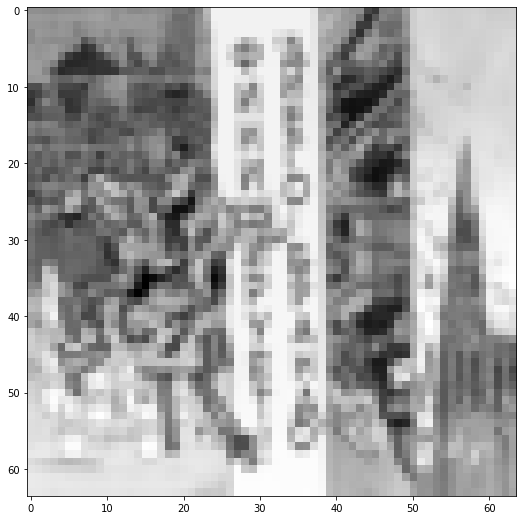

In [58]:
plt.figure(figsize=[16, 9])
plt.imshow(img[0], cmap='gray')

In [59]:
img[0].max()

tensor(1.)

In [60]:
model.eval()

MangaModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.5, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (14): ReLU()
    (15): Dropout2d(p=0.5, inplace=False)
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [61]:
model.encoder(a.__getitem__(100).unsqueeze(0))

tensor([[-6.4452e-05,  3.8774e-05,  5.7270e-05,  7.1323e-05,  7.9178e-05,
          1.8110e-05,  6.3073e-05,  1.4228e-04, -2.2145e-04,  3.6024e-05,
         -4.5642e-05,  3.0014e-04,  4.5399e-05, -1.4723e-04,  4.6408e-05,
          7.9537e-05,  4.8682e-05, -5.1865e-05,  2.6616e-05, -1.2311e-04,
          8.3905e-06,  9.7526e-06, -3.3911e-05,  1.0568e-04, -8.5876e-05,
          1.5742e-05,  5.6101e-05,  2.6950e-05, -1.3150e-04,  7.4419e-06,
          5.2149e-05, -6.8317e-05, -3.0094e-06, -3.3578e-05,  1.1808e-04,
         -7.5860e-05,  8.4596e-05, -5.9671e-05, -7.6294e-05, -8.3480e-06]],
       grad_fn=<AddmmBackward>)

In [62]:
model.encoder(a.__getitem__(1).unsqueeze(0))

tensor([[ 3.9576e-05, -6.0152e-05,  9.0797e-05,  2.7113e-05,  5.6482e-05,
          1.0028e-04, -7.0649e-05,  1.7723e-04, -2.6314e-05,  3.5926e-06,
         -1.2984e-04,  1.7998e-04, -3.8658e-05, -1.7802e-04,  1.3998e-04,
          9.8426e-05, -3.6350e-05, -4.2069e-06,  4.3635e-05, -5.3744e-05,
          8.3135e-05, -1.2211e-05,  1.8205e-05,  1.8109e-04, -1.1164e-04,
         -6.6114e-06,  1.4202e-04, -2.2395e-05, -1.0330e-04,  3.8842e-05,
          2.6373e-05, -5.9451e-06,  7.5749e-05, -2.0360e-05,  1.4813e-04,
         -1.6766e-05,  1.6139e-04, -2.5040e-05,  7.4559e-06,  2.1098e-05]],
       grad_fn=<AddmmBackward>)

Epoch 13:  82%|████████████████████████████████████████▊         | 76/93 [03:06<00:41,  2.42s/it, loss=0.0834, v_num=8]

In [84]:
sas = model(a.__getitem__(0).unsqueeze(0))[0]

In [85]:
sas

tensor([[[[0.6153, 0.7851, 0.7501,  ..., 0.8055, 0.7861, 0.6784],
          [0.7471, 0.7915, 0.7813,  ..., 0.7867, 0.7858, 0.8246],
          [0.7470, 0.7742, 0.7623,  ..., 0.7671, 0.7682, 0.7706],
          ...,
          [0.7693, 0.7827, 0.7766,  ..., 0.7571, 0.7700, 0.7627],
          [0.7217, 0.7866, 0.7596,  ..., 0.7757, 0.7703, 0.7844],
          [0.6327, 0.7446, 0.7214,  ..., 0.7270, 0.7130, 0.4966]]]],
       grad_fn=<SlowConvTranspose2DBackward>)

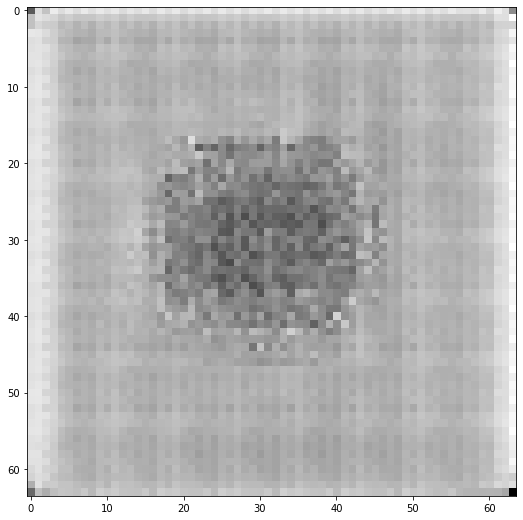

In [86]:
plt.figure(figsize=[16, 9])
plt.imshow(sas.detach().numpy()[0][0], cmap='gray')